### 1. REINFORCE Algorithm

We will treat now the REINFORCE Algorithm to understand better how it works and the implementations that can be done. We no longer use action-value methods but we use policy approximation.

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
# Create environment
class GridWorld:
    """
    A simple 4x4 GridWorld environment:
    - Start at (0,0), goal at (3,3).
    - Actions: 0=Up, 1=Down, 2=Left, 3=Right.
    - Reward: -1 for each step, +10 if goal is reached.
    """
    def __init__(self):
        self.size = 4               # Grid dimension: 4x4
        self.start = (0, 0)         # Start position
        self.goal = (3, 3)          # Goal position
        self.state = self.start     # Current state

    def reset(self):
        """Reset the environment to the starting state."""
        self.state = self.start
        return self.state

    def step(self, action):
        """
        Apply an action to move in the grid. 
        Returns (next_state, reward, done).
        """
        x, y = self.state
        if action == 0:    # Up
            new_state = (max(x - 1, 0), y)
        elif action == 1:  # Down
            new_state = (min(x + 1, self.size - 1), y)
        elif action == 2:  # Left
            new_state = (x, max(y - 1, 0))
        elif action == 3:  # Right
            new_state = (x, min(y + 1, self.size - 1))
        else:
            new_state = self.state

        self.state = new_state

        # Reward function
        if new_state == self.goal:
            reward = 10
            done = True
        else:
            reward = -1
            done = False

        return new_state, reward, done

In [3]:
# Create policy and baseline networks
def build_policy_network():
    """
    Builds a policy network that outputs action logits for the 4 actions
    given a 2D normalized state input.
    """
    model = Sequential([
        Dense(16, activation='relu', input_shape=(2,)),
        Dense(4)  # Output logits for actions [up, down, left, right]
    ])
    return model

def build_value_network():
    """
    Builds a value network (baseline) that outputs a single scalar
    estimating the value of the state.
    """
    model = Sequential([
        Dense(16, activation='relu', input_shape=(2,)),
        Dense(1)  # Scalar value output
    ])
    return model

In [4]:
# Functions for plotting results
def plot_total_rewards(episode_rewards):
    """
    Plot the total reward per episode along with:
      - A dashed line for the optimal reward (here given as 5 for reference),
      - A moving mean (using a window of ±5 episodes, window size = 11) as a red dashed line,
      - A blue shaded area (alpha = 0.3) representing the moving mean ± 2 standard deviations.
    """
    episodes_range = np.arange(len(episode_rewards))
    window_size = 11  # ±5 episodes around the current one
    half_window = window_size // 2

    # Compute moving mean using convolution (with 'same' mode)
    moving_mean = np.convolve(episode_rewards, np.ones(window_size)/window_size, mode='same')

    # Compute moving standard deviation using a sliding window
    moving_std = np.empty(len(episode_rewards))
    for i in range(len(episode_rewards)):
        start = max(0, i - half_window)
        end = min(len(episode_rewards), i + half_window + 1)
        moving_std[i] = np.std(episode_rewards[start:end])
    
    plt.figure(figsize=(6, 4))
    plt.plot(episodes_range, episode_rewards, label='Episode Reward')
    plt.hlines(5, 0, len(episode_rewards), colors='k', linestyles='dashed', label='Optimal Reward')
    plt.plot(episodes_range, moving_mean, color='red', label='Moving Mean')
    plt.fill_between(episodes_range, moving_mean - 2 * moving_std, moving_mean + 2 * moving_std, color='blue', alpha=0.3, label='± 2σ')
    plt.ylim(-110, 10)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Total Reward per Episode")
    plt.legend()
    plt.show()

def plot_state_visits(state_visits):
    """
    Display a heatmap showing how often each state (grid cell) was visited.
    """
    plt.figure(figsize=(6, 5))
    plt.imshow(state_visits, cmap='viridis', origin='upper')
    plt.title("State Visit Frequencies (Heatmap)")
    plt.xlabel("Grid Column")
    plt.ylabel("Grid Row")
    plt.colorbar(label='Visit Count')
    plt.show()

def plot_policy_distribution(policy_net, env):
    """
    Visualize the learned policy distribution by drawing arrows in each cell.
    Arrow lengths are proportional to the action probabilities.
    """
    directions = {
        0: (0, -1),  # Up
        1: (0, 1),   # Down
        2: (-1, 0),  # Left
        3: (1, 0)    # Right
    }
    scale = 0.4  # Scaling factor for arrow lengths.

    plt.figure(figsize=(6, 6))
    for i in range(env.size):  # Row index
        for j in range(env.size):  # Column index
            # Create normalized state for cell (i, j)
            state_norm = np.array([[i / (env.size - 1), j / (env.size - 1)]], dtype=np.float32)
            logits = policy_net(state_norm)
            probs = tf.nn.softmax(logits).numpy()[0]
            
            # Draw an arrow for each action
            for action in range(4):
                dx, dy = directions[action]
                plt.quiver(
                    j, i,  # Arrow starts at (column, row)
                    dx * probs[action] * scale,
                    dy * probs[action] * scale,
                    angles='xy', scale_units='xy', scale=1,
                    color='black', alpha=0.7
                )

    plt.gca().invert_yaxis()
    plt.xticks(np.arange(env.size))
    plt.yticks(np.arange(env.size))
    plt.xlim(-0.5, env.size - 0.5)
    plt.ylim(-0.5, env.size - 0.5)
    plt.title("Policy Distribution (Action Probability)")
    plt.show()

#### 1.1. Basic REINFORCE Algorithm

In [5]:
def compute_returns(rewards, gamma):
    """
    Given a list of rewards and a discount factor gamma, compute the
    discounted return (G) for each timestep in the episode.
    """
    returns = []
    G = 0
    # Iterate rewards in reverse to compute Gt
    for r in rewards[::-1]:
        G = r + gamma * G
        returns.insert(0, G)
    return np.array(returns, dtype=np.float32)

# REINFORCE ALGORITHM

if __name__ == "__main__":
    # Hyperparameters
    num_episodes = 500
    gamma = 0.99
    policy_lr = 0.001
    max_steps = 100

    # Build the policy network (our approximation)
    policy_net = build_policy_network()
    policy_optimizer = Adam(learning_rate=policy_lr)

    # Create environment
    env = GridWorld()

    # Containers for logging values during training
    episode_rewards = []                           # Total reward per episode
    state_visits = np.zeros((env.size, env.size))  # Visit count per grid cell

    # Training loop: FOR EACH EPISODE
    for episode in range(num_episodes):
        states = []    # Store normalized states of this episode
        actions = []   # Store actions taken
        rewards = []   # Store rewards received

        state = env.reset()   # Reset environment to start state
        total_reward = 0
        done = False

        # Generate one episode (up to T=max_steps)
        for step in range(max_steps):
            # Record state visit count for visualization later
            x, y = state
            state_visits[x, y] += 1

            # Normalize state for neural network input
            state_norm = np.array([x / (env.size - 1), y / (env.size - 1)], dtype=np.float32)
            states.append(state_norm)

            # Get action probabilities from the policy network
            logits = policy_net(np.expand_dims(state_norm, axis=0))  # Policy input: state, policy output: logit
            probs = tf.nn.softmax(logits).numpy()[0]                 # Convert logits to probabilities
            action = np.random.choice(4, p=probs)                    # Choose action based on probabilities
            actions.append(action)

            # Take the action in the environment
            next_state, reward, done = env.step(action)
            rewards.append(reward)
            total_reward += reward

            state = next_state
            if done:
                break

        # Store the total reward of the episode for plotting later
        episode_rewards.append(total_reward)

        # EPISODE ENDS HERE

        # FOR EACH TIMESTEP IN THE EPISODE

        # G: Compute returns (discounted cumulative rewards)
        returns = compute_returns(rewards, gamma)

        # theta: update policy network using REINFORCE
        for state_val, action, G in zip(states, actions, returns):
            # Convert the numpy state to a TensorFlow tensor
            state_tensor = tf.convert_to_tensor([state_val], dtype=tf.float32)
            with tf.GradientTape() as tape:
                # Forward pass: compute the logits and convert to probabilities
                logits = policy_net(state_tensor)
                action_probs = tf.nn.softmax(logits)
                # Compute the log probability for the taken action
                log_prob = tf.math.log(action_probs[0, action] + 1e-8)
                # REINFORCE loss: - (log_prob * G)
                policy_loss = -log_prob * G
            # Compute gradients and update policy parameters
            policy_grads = tape.gradient(policy_loss, policy_net.trainable_variables)
            policy_optimizer.apply_gradients(zip(policy_grads, policy_net.trainable_variables))

c:\Users\imcir\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


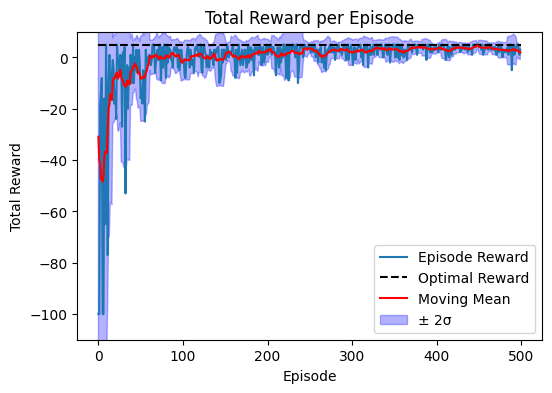

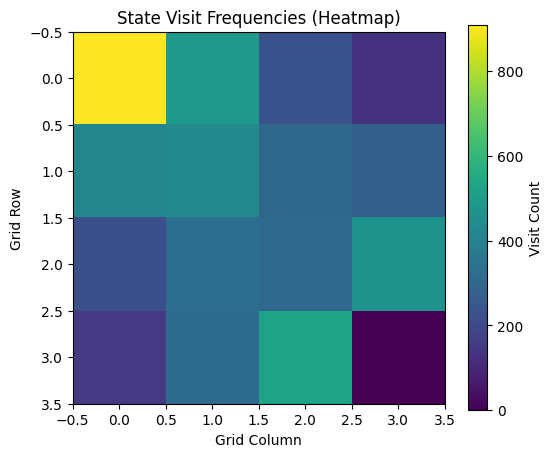

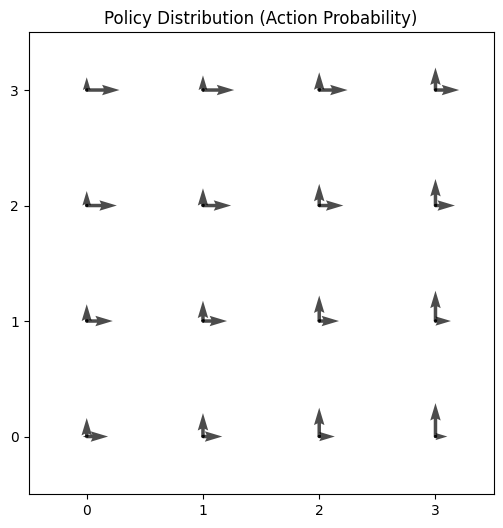

In [6]:
# Plotting the results

# 1. Plot total reward over episodes
plot_total_rewards(episode_rewards)

# 2. Plot state visits (heatmap)
plot_state_visits(state_visits)

# 3. Visualize policy distribution
plot_policy_distribution(policy_net, env)

#### 1.2. REINFORCE Algorithm with baseline

In [7]:
# REINFORCE ALGORITHM WITH BASELINE
if __name__ == "__main__":
    # Hyperparameters
    num_episodes = 500
    gamma = 0.99
    policy_lr = 0.001
    value_lr = 0.05
    max_steps = 100

    # Build networks and optimizers
    policy_net = build_policy_network()
    value_net = build_value_network()
    policy_optimizer = Adam(learning_rate=policy_lr)
    value_optimizer = Adam(learning_rate=value_lr)

    # Create environment
    env = GridWorld()

    # Containers for logging/plotting
    episode_rewards = []
    state_visits = np.zeros((env.size, env.size))

    # Training loop: FOR EACH EPISODE
    for episode in range(num_episodes):
        # Lists to store the states, actions, rewards for the episode
        states = []
        actions = []
        rewards = []

        # Reset environment at the start of each episode
        state = env.reset()
        total_reward = 0
        done = False

        # Generate one episode (up to T=max_steps)
        for step in range(max_steps):
            # Track how many times each cell is visited
            x, y = state
            state_visits[x, y] += 1

            # Normalize state to [0,1] (for NN efficiency)
            state_norm = np.array([x / (env.size - 1), y / (env.size - 1)], dtype=np.float32)
            states.append(state_norm)

            # Get action probabilities from the policy network
            logits = policy_net(np.expand_dims(state_norm, axis=0))  # Give the state to the policy and get the logit
            probs = tf.nn.softmax(logits).numpy()[0]                 # Convert the logit to probabilities
            action = np.random.choice(4, p=probs)                    # Choose an action based on the probabilities
            actions.append(action)

            # Take step in environment
            next_state, reward, done = env.step(action)
            rewards.append(reward)
            total_reward += reward

            # Transition to next state
            state = next_state

            if done:
                break

        episode_rewards.append(total_reward)

        # EPISODE ENDS HERE

        # FOR EACH TIMESTEP IN THE EPISODE

        # G: Compute returns
        returns = compute_returns(rewards, gamma)

        # Update the networks for each step in the episode
        for state_val, action, G in zip(states, actions, returns):
            # Convert the numpy state to a Tensor
            state_tensor = tf.convert_to_tensor([state_val], dtype=tf.float32)

            # 1) Update value network (baseline): delta (value_loss) & w (value_grads)
            with tf.GradientTape() as tape:
                value_est = value_net(state_tensor)[0, 0]
                value_loss = tf.square(G - value_est)
            value_grads = tape.gradient(value_loss, value_net.trainable_variables)
            value_optimizer.apply_gradients(zip(value_grads, value_net.trainable_variables))

            # 2) Update policy network (approximation): delta (advantage) & theta (policy_grads)
            with tf.GradientTape() as tape:
                logits = policy_net(state_tensor)
                action_probs = tf.nn.softmax(logits)
                log_prob = tf.math.log(action_probs[0, action] + 1e-8)

                # Advantage = return - baseline
                baseline = value_net(state_tensor)[0, 0]
                advantage = G - baseline

                # REINFORCE loss with baseline
                policy_loss = -log_prob * advantage
            policy_grads = tape.gradient(policy_loss, policy_net.trainable_variables)
            policy_optimizer.apply_gradients(zip(policy_grads, policy_net.trainable_variables))

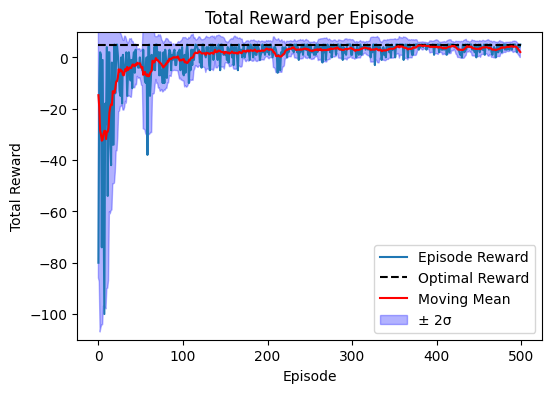

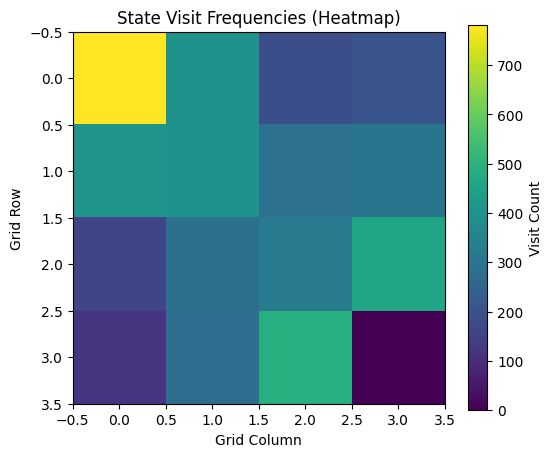

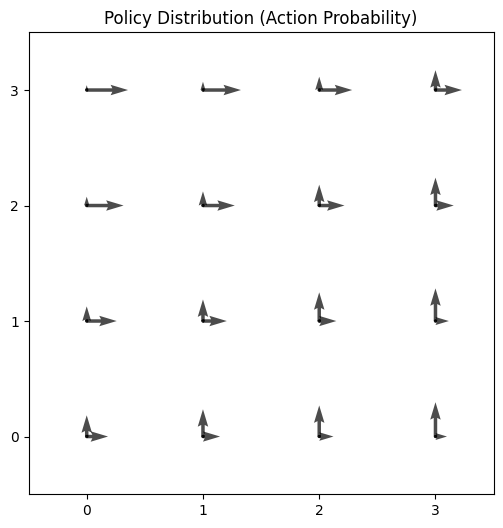

In [8]:
# Plotting the results

# 1. Plot total reward over episodes
plot_total_rewards(episode_rewards)

# 2. Plot state visits (heatmap)
plot_state_visits(state_visits)

# 3. Visualize policy distribution
plot_policy_distribution(policy_net, env)

#### 1.3. Actor-Critic methods

In [9]:
if __name__ == "__main__":
    # Hyperparameters
    num_episodes = 500
    gamma = 0.99
    policy_lr = 0.001
    value_lr = 0.05
    max_steps = 100

    # Build actor (policy) and critic (value) networks
    policy_net = build_policy_network()
    value_net = build_value_network()
    policy_optimizer = Adam(learning_rate=policy_lr)
    value_optimizer = Adam(learning_rate=value_lr)

    # Create environment
    env = GridWorld()

    # Containers for logging values during training
    episode_rewards = []                # Total reward per episode
    state_visits = np.zeros((env.size, env.size))  # Visit count per grid cell

    # Training loop: FOR EACH EPISODE
    for episode in range(num_episodes):

        # Inicializamos S
        state = env.reset()
        total_reward = 0
        done = False

        # FOR EACH TIMESTEP (WE LIMIT THE STEPS BUT IS EQUAL TO S TERMINAL)
        for step in range(max_steps):
            # Record state visit
            x, y = state
            state_visits[x, y] += 1

            # Normalize state for NN input
            state_norm = np.array([x / (env.size - 1), y / (env.size - 1)], dtype=np.float32)

            # Convert to TF tensors
            state_tensor = tf.convert_to_tensor([state_norm], dtype=tf.float32)

            # ----- Actor forward pass to get action probabilities
            with tf.GradientTape() as policy_tape, tf.GradientTape() as value_tape:
                logits = policy_net(state_tensor)
                action_probs = tf.nn.softmax(logits)
                # Sample an action from the distribution
                action = np.random.choice(4, p=action_probs.numpy()[0])

                # ----- Critic forward pass (value estimation)
                value_est = value_net(state_tensor)[0, 0]

            # Step in environment
            next_state, reward, done = env.step(action)
            total_reward += reward

            # If next_state is terminal, v(s') = 0
            if done:
                next_value_est = 0.0
            else:
                nx, ny = next_state
                next_state_norm = np.array([nx/(env.size - 1), ny/(env.size - 1)], dtype=np.float32)
                next_state_tensor = tf.convert_to_tensor([next_state_norm], dtype=tf.float32)
                next_value_est = value_net(next_state_tensor)[0, 0].numpy()

            # 1-step TD target
            td_target = reward + gamma * next_value_est

            # delta: TD error
            delta = td_target - value_est

            # ----- Update Critic (w)
            with value_tape:
                # Recompute value for gradient
                value_est2 = value_net(state_tensor)[0, 0]
                value_loss = tf.square(td_target - value_est2)
            value_grads = value_tape.gradient(value_loss, value_net.trainable_variables)
            value_optimizer.apply_gradients(zip(value_grads, value_net.trainable_variables))

            # ----- Update Actor (theta)
            with policy_tape:
                # Recompute the action probabilities
                logits2 = policy_net(state_tensor)
                action_probs2 = tf.nn.softmax(logits2)
                log_prob = tf.math.log(action_probs2[0, action] + 1e-8)
                # Actor update: we want to maximize delta * log_prob => minimize negative
                entropy = -tf.reduce_sum(action_probs2 * tf.math.log(action_probs2 + 1e-8))
                policy_loss = -log_prob * delta - 0.01 * entropy
            policy_grads = policy_tape.gradient(policy_loss, policy_net.trainable_variables)
            policy_optimizer.apply_gradients(zip(policy_grads, policy_net.trainable_variables))

            # Move to next state
            state = next_state
            if done:
                break

        # Track total reward in this episode
        episode_rewards.append(total_reward)

        # EPISODE ENDS HERE, THE UPDATE OCCURS DURING THE EPISODE

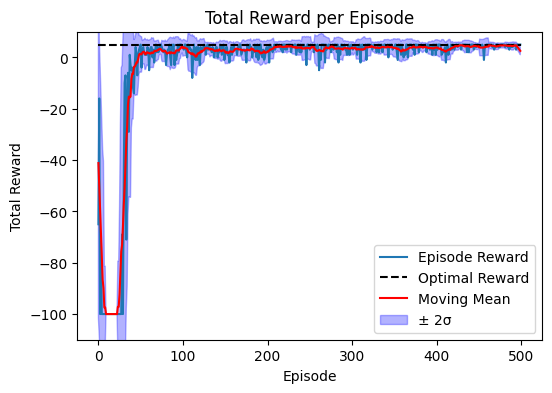

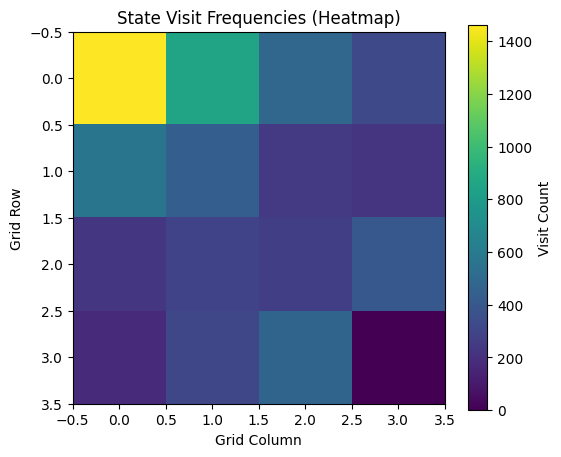

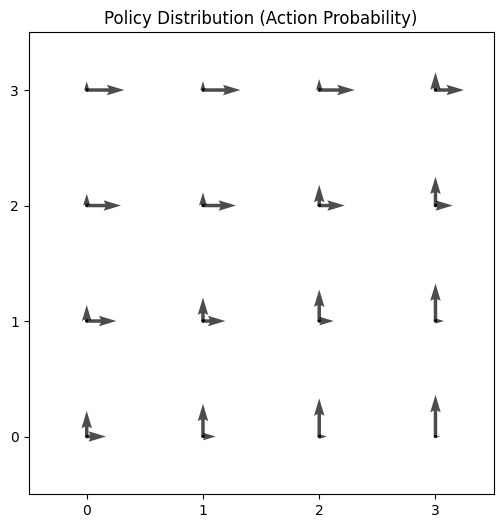

In [10]:
plot_total_rewards(episode_rewards)
plot_state_visits(state_visits)
plot_policy_distribution(policy_net, env)